In [2]:
!pip install ultralytics -q

In [4]:
!pip install datasets -q

In [9]:
from ultralytics import YOLO
from datasets import load_dataset
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from huggingface_hub import login # Import the login function from huggingface_hub

# Authenticate with your Hugging Face token
login() # This will prompt you to enter your token if you haven't already logged in.

# Carregar o dataset
dataset = load_dataset("gabraken/mtg-detection", cache_dir="E:\mtg-card-detector\data_cache")

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

In [3]:
# Exibir informações do dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'annotation', 'metadata'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['id', 'image', 'annotation', 'metadata'],
        num_rows: 3000
    })
})


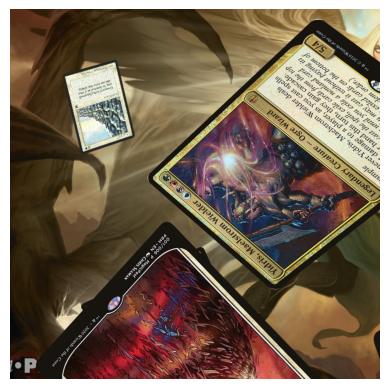

[[1.2141401486057726, 1.4678795924014163, 0.0, -0.17349060781084452, 0.0], [2.126094638022354, 1.3080573306380665, 0.0, -1.955544810963152, 1.0], [1.881311746723621, 0.7035495095398802, 0.0, 2.9247943499869393, 2.0], [1.0128075060895585, 0.894846267436338, 0.0, 1.2329234052958977, 3.0], [0.5128744844531262, 0.6536777500564362, 1.0, 2.6908337028015636, 0.0], [0.20362036721170734, 0.8033541002628757, 1.0, 1.0269245136136984, 1.0], [0.2962033469848015, 0.9564584958958099, 0.0, -0.4437704036117622, 2.0], [0.5887359654229251, 0.817390012011563, 0.0, -2.004723663743774, 3.0], [0.712893015930856, 0.737710908623858, 1.0, -0.6696589493956299, 0.0], [1.2209819970007538, 0.335457264740642, 0.0, -2.5052416725911875, 1.0], [0.8312637525655342, 0.04749939216069357, 1.0, 2.390649441045188, 2.0], [0.39182423791974497, 0.45765457413592836, 1.0, 0.7172775927805438, 3.0], [0.32993400552066, 0.34060526603537145, 1.0, -1.8054134124721006, 0.0], [0.28287502505085343, 0.14372131621371498, 1.0, 2.861263343698

In [12]:
# Selecionar uma amostra do dataset
sample = dataset['train'][0]

# Carregar a imagem
image = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)

# Exibir a imagem usando matplotlib
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Exibir anotações
print(sample['annotation'])
print(sample['metadata'])


In [15]:
#Normalização e tratamento dos dados de treino para o YOLO OBB
import os
import cv2
import numpy as np
import json

# Criação de diretórios
os.makedirs('datasets/data/images/train', exist_ok=True)
os.makedirs('datasets/data/labels/train', exist_ok=True)

# Mapeamento de cor para ID de classe
color_to_class = {
    "W": 0,  # Branco (White)
    "U": 1,  # Azul (Blue)
    "B": 2,  # Preto (Black)
    "R": 3,  # Vermelho (Red)
    "G": 4,  # Verde (Green)
    "C": 5,  # Incolor
    "M": 6   # Multicor
}

# Agrupa os pontos de cada carta com base no corner_id == 0
def group_cards(annotation):
    cards = []
    i = 0
    while i < len(annotation):
        if int(annotation[i][4]) == 0:  # início de nova carta
            card = [annotation[i]]
            for j in range(1, 4):
                if i + j < len(annotation) and int(annotation[i + j][4]) == j:
                    card.append(annotation[i + j])
            if len(card) == 4:
                cards.append(card)
            i += 4
        else:
            i += 1
    return cards

# Converte uma imagem + anotação para arquivos de treino YOLO OBB (normalizado)
def convert_annotation(sample, idx):
    image = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)
    image_path = f'datasets/data/images/train/{idx}.jpg'
    label_path = f'datasets/data/labels/train/{idx}.txt'
    h, w = image.shape[:2]
    cv2.imwrite(image_path, image)

    cards = group_cards(sample['annotation'])

    with open(label_path, 'w') as f:
        for card in cards:
            if len(card) != 4:
                continue

            # Pegamos os 4 pontos normalizados (x, y entre 0 e 1)
            points = [(max(min(p[0], 1.0), 0.0), max(min(p[1], 1.0), 0.0)) for p in card]
            coords = [f"{x:.6f} {y:.6f}" for x, y in points]

            # Identifica a cor da carta a partir dos metadados
            metadata = json.loads(sample['metadata'])
            if not metadata:
                continue
            color_ids = metadata[cards.index(card)]['colors']

            if not color_ids:
                class_id = color_to_class["C"]  # Incolor
            elif len(color_ids) > 1:
                class_id = color_to_class["M"]  # Multicor
            else:
                class_id = color_to_class.get(color_ids[0], color_to_class["C"])  # Cor única ou fallback

            f.write(f"{class_id} " + " ".join(coords) + "\n")

# Aplicar ao conjunto de treino
for idx, sample in enumerate(dataset['train']):
    convert_annotation(sample, idx)
    print(f"Convertido: {idx}")


Convertido: 0
Convertido: 1
Convertido: 2
Convertido: 3
Convertido: 4
Convertido: 5
Convertido: 3
Convertido: 4
Convertido: 5
Convertido: 6
Convertido: 7
Convertido: 8
Convertido: 6
Convertido: 7
Convertido: 8
Convertido: 9
Convertido: 10
Convertido: 11
Convertido: 12
Convertido: 9
Convertido: 10
Convertido: 11
Convertido: 12
Convertido: 13
Convertido: 14
Convertido: 15
Convertido: 16
Convertido: 13
Convertido: 14
Convertido: 15
Convertido: 16
Convertido: 17
Convertido: 18
Convertido: 19
Convertido: 20
Convertido: 17
Convertido: 18
Convertido: 19
Convertido: 20
Convertido: 21
Convertido: 22
Convertido: 23
Convertido: 24
Convertido: 21
Convertido: 22
Convertido: 23
Convertido: 24
Convertido: 25
Convertido: 26
Convertido: 27
Convertido: 25
Convertido: 26
Convertido: 27
Convertido: 28
Convertido: 29
Convertido: 30
Convertido: 28
Convertido: 29
Convertido: 30
Convertido: 31
Convertido: 32
Convertido: 33
Convertido: 34
Convertido: 31
Convertido: 32
Convertido: 33
Convertido: 34
Convertido: 

In [16]:
#Normalização e tratamento dos dados de TESTE para o YOLO OBB
import os
import cv2
import numpy as np
import json

# Criação de diretórios
os.makedirs('datasets/data/images/test', exist_ok=True)
os.makedirs('datasets/data/labels/test', exist_ok=True)

# Mapeamento de cor para ID de classe
color_to_class = {
    "W": 0,  # Branco (White)
    "U": 1,  # Azul (Blue)
    "B": 2,  # Preto (Black)
    "R": 3,  # Vermelho (Red)
    "G": 4,  # Verde (Green)
    "C": 5,  # Incolor
    "M": 6   # Multicor
}

# Agrupa os pontos de cada carta com base no corner_id == 0
def group_cards(annotation):
    cards = []
    i = 0
    while i < len(annotation):
        if int(annotation[i][4]) == 0:  # início de nova carta
            card = [annotation[i]]
            for j in range(1, 4):
                if i + j < len(annotation) and int(annotation[i + j][4]) == j:
                    card.append(annotation[i + j])
            if len(card) == 4:
                cards.append(card)
            i += 4
        else:
            i += 1
    return cards

# Converte uma imagem + anotação para arquivos de treino YOLO OBB (normalizado)
def convert_annotation(sample, idx):
    image = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)
    image_path = f'datasets/data/images/test/{idx}.jpg'
    label_path = f'datasets/data/labels/test/{idx}.txt'
    h, w = image.shape[:2]
    cv2.imwrite(image_path, image)

    cards = group_cards(sample['annotation'])

    with open(label_path, 'w') as f:
        for card in cards:
            if len(card) != 4:
                continue

            # Pegamos os 4 pontos normalizados (x, y entre 0 e 1)
            points = [(max(min(p[0], 1.0), 0.0), max(min(p[1], 1.0), 0.0)) for p in card]
            coords = [f"{x:.6f} {y:.6f}" for x, y in points]

            # Identifica a cor da carta a partir dos metadados
            metadata = json.loads(sample['metadata'])
            if not metadata:
                continue
            color_ids = metadata[cards.index(card)]['colors']

            if not color_ids:
                class_id = color_to_class["C"]  # Incolor
            elif len(color_ids) > 1:
                class_id = color_to_class["M"]  # Multicor
            else:
                class_id = color_to_class.get(color_ids[0], color_to_class["C"])  # Cor única ou fallback

            f.write(f"{class_id} " + " ".join(coords) + "\n")

# Aplicar ao conjunto de treino
for idx, sample in enumerate(dataset['test']):
    convert_annotation(sample, idx)
    print(f"Convertido: {idx}")


Convertido: 0
Convertido: 1
Convertido: 1
Convertido: 2
Convertido: 2
Convertido: 3
Convertido: 3
Convertido: 4
Convertido: 4
Convertido: 5
Convertido: 6
Convertido: 7
Convertido: 8
Convertido: 9
Convertido: 10
Convertido: 5
Convertido: 6
Convertido: 7
Convertido: 8
Convertido: 9
Convertido: 10
Convertido: 11
Convertido: 11
Convertido: 12
Convertido: 13
Convertido: 12
Convertido: 13
Convertido: 14
Convertido: 15
Convertido: 16
Convertido: 14
Convertido: 15
Convertido: 16
Convertido: 17
Convertido: 18
Convertido: 17
Convertido: 18
Convertido: 19
Convertido: 19
Convertido: 20
Convertido: 21
Convertido: 22
Convertido: 23
Convertido: 20
Convertido: 21
Convertido: 22
Convertido: 23
Convertido: 24
Convertido: 25
Convertido: 26
Convertido: 27
Convertido: 24
Convertido: 25
Convertido: 26
Convertido: 27
Convertido: 28
Convertido: 29
Convertido: 28
Convertido: 29
Convertido: 30
Convertido: 31
Convertido: 30
Convertido: 31
Convertido: 32
Convertido: 33
Convertido: 32
Convertido: 33
Convertido: 34

In [48]:
#Desenha a imagem e o overlay a partir do dataset puro
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Caminhos da imagem e do label
img_path = "datasets/data/images/train/0.jpg"
label_path = "datasets/data/labels/train/0.txt"

# Abrir imagem
img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(img)
w, h = img.size

# Ler labels e desenhar as quinas como polígono
with open(label_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 9:
            print(f"Ignorando linha inválida: {line.strip()}")
            continue

        try:
            coords = list(map(float, parts[1:9]))
            class_id = int(float(parts[8]))
        except ValueError:
            print(f"Erro ao converter linha: {line.strip()}")
            continue

        # Convertendo coordenadas normalizadas para pixels
        points = [(coords[i] * w, coords[i+1] * h) for i in range(0, 8, 2)]
        draw.polygon(points, outline="red", width=3)
        draw.text((points[0][0], points[0][1] - 10), f"class {class_id}", fill="red")

# Mostrar imagem
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
yaml_content = """
train: data/images/train
val: data/images/test

nc: 7  # numero de classes
names: ["Branco (White)", "Azul (Blue)", "Preto (Black)", "Vermelho (Red)", "Verde (Green)", "Incolor", "Multicor"]  # nome da(s) classe(s)

# Para YOLO com caixas rotacionadas (OBB)
obb: true

"""

with open("mtg.yaml", "w") as f:
    f.write(yaml_content)

In [17]:
from collections import Counter
import os

labels_dir = "datasets/data/labels/train"
class_counts = Counter()

for file in os.listdir(labels_dir):
    with open(os.path.join(labels_dir, file), "r") as f:
        for line in f:
            class_id = line.strip().split()[0]
            class_counts[int(class_id)] += 1

print("Distribuição de classes no conjunto de treino:")
for class_id, count in sorted(class_counts.items()):
    print(f"Classe {class_id}: {count} amostras")


Distribuição de classes no conjunto de treino:
Classe 0: 3746 amostras
Classe 1: 3752 amostras
Classe 2: 4154 amostras
Classe 3: 4226 amostras
Classe 4: 4170 amostras
Classe 5: 7801 amostras
Classe 6: 4801 amostras


In [1]:
!head datasets/data/labels/train/3367.txt

0 1.000000 1.000000 0.554758 1.000000 0.965663 1.000000 1.000000 1.000000
0 0.100405 0.121821 0.035283 0.104208 0.024190 0.146819 0.088391 0.164976
0 0.626030 0.713360 0.966120 0.913518 1.000000 0.683224 0.777045 0.479922


In [10]:
!rm -rf /content/datasets/data

In [1]:
#Checking the GPU and PyTorch version
import torch
print(torch.__version__)           # Should show ≥2.0.0
print(torch.cuda.is_available())   # Must return True
print(torch.cuda.get_device_name(0))  # Should show "GeForce GTX 1650 SUPER"



2.6.0+cu118
True
NVIDIA GeForce GTX 1650 SUPER


In [ ]:
#Treinar modelo
from ultralytics import YOLO

data_yaml = 'mtg.yaml'

model = YOLO('E:\\mtg-card-detector\\runs\\obb\\train_1650_yolo11n_obb\\weights\\last.pt')  # Load the last trained model
model.train(
    data=data_yaml,
    epochs=150,
    imgsz=640,
    batch=-1,
    name='train_1650_yolo11n_obb',
    device='0',
    resume=True, # Resume training from the last checkpoint
    # lr0=0.01 , # Adjust learning rate
    augment=True,  # Enable data augmentation
    patience=5  
)

In [6]:
#Testar modelo
from ultralytics import YOLO

# Carregue o modelo treinado
model = YOLO("runs/obb/train_1650_yolo11s3/weights/best.pt")

# Avaliar o modelo no conjunto de validação
metrics = model.val(data="mtg.yaml", imgsz=640, iou=0.5)

# Exibir métricas principais
print("\n--- Métricas da Validação ---")
print(f"Precision:  {metrics.box.mp:.4f}")
print(f"Recall:     {metrics.box.mr:.4f}")
print(f"mAP@0.5:    {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Classes:    {metrics.box.nc}")


Ultralytics 8.3.102  Python-3.10.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 SUPER, 4096MiB)
YOLO11s-obb summary (fused): 109 layers, 9,701,496 parameters, 0 gradients, 22.3 GFLOPs


val: Scanning E:\mtg-card-detector\datasets\data\labels\test.cache... 3000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:00<?, ?it/s]

val: WARNING  E:\mtg-card-detector\datasets\data\images\test\0.jpg: 3 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1.jpg: 2 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1016.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1018.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1026.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1035.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1055.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\108.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1113.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1127.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-d


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [01:13<00:00,  2.56it/s]


                   all       3000       9606       0.83      0.532      0.587      0.524
        Branco (White)        942       1123      0.719      0.526       0.55      0.492
           Azul (Blue)        917       1084      0.908      0.565      0.617       0.55
         Preto (Black)        982       1172      0.752      0.539      0.568       0.51
        Vermelho (Red)       1071       1271      0.905      0.576      0.632      0.566
         Verde (Green)       1026       1270      0.916      0.515      0.578      0.512
               Incolor       1676       2292      0.889      0.462      0.586      0.514
              Multicor       1148       1394      0.722      0.543      0.575      0.521
Speed: 1.1ms preprocess, 12.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\obb\val

--- Métricas da Validação ---
Precision:  0.8301
Recall:     0.5324
mAP@0.5:    0.5867
mAP@0.5:0.95: 0.5236
Classes:    7



image 1/1 e:\mtg-card-detector\IMG_8231.HEIC: 640x480 17.1ms
Speed: 3.4ms preprocess, 17.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)

🔍 10 cartas encontradas
 - Carta 1: Classe = Preto, Confiança = 0.96
 - Carta 2: Classe = Multicor, Confiança = 0.95
 - Carta 3: Classe = Multicor, Confiança = 0.95
 - Carta 4: Classe = Verde, Confiança = 0.93
 - Carta 5: Classe = Branco, Confiança = 0.88
 - Carta 6: Classe = Azul, Confiança = 0.87
 - Carta 7: Classe = Preto, Confiança = 0.84
 - Carta 8: Classe = Azul, Confiança = 0.79
 - Carta 9: Classe = Multicor, Confiança = 0.64
 - Carta 10: Classe = Incolor, Confiança = 0.61


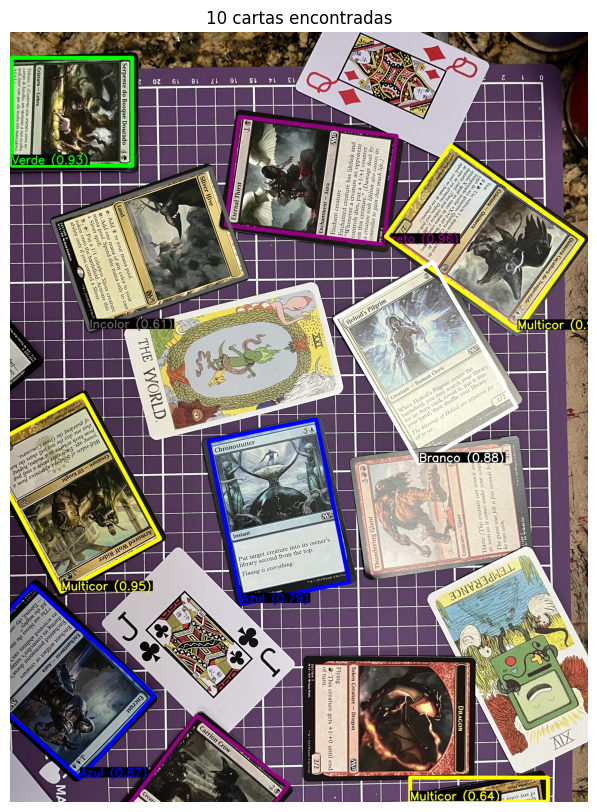

In [2]:
# TESTE - Usar Modelo
from ultralytics import YOLO
import cv2
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Mapeamento de classes
COLOR_MAP = {
    0: ("Branco", (255, 255, 255)),
    1: ("Azul", (255, 0, 0)),
    2: ("Preto", (128, 0, 150)),
    3: ("Vermelho", (0, 0, 255)),
    4: ("Verde", (0, 255, 0)),
    5: ("Incolor", (100, 100, 100)),
    6: ("Multicor", (0, 255, 255))
}

# Carrega o modelo
model = YOLO("runs/obb/train_1650_yolo11n_obb/weights/best.pt")

# Faz a predição
results = model("IMG_8231.HEIC", conf=0.60)
r = results[0]
img = r.orig_img.copy()
obbs = r.obb
num_cartas = len(obbs)

print(f"\n🔍 {num_cartas} cartas encontradas")

# Process each detection
for i, obb in enumerate(obbs):
    conf = float(obb.conf[0])
    xyxyxyxy = obb.xyxyxyxy[0].cpu().numpy().reshape(-1, 2)
    class_id = int(obb.cls[0])
    
    # Get the full class name and box color
    class_name, box_color = COLOR_MAP.get(class_id, ("?", (1, 1, 1)))
    
    pts = np.int32(xyxyxyxy).reshape((-1, 1, 2))
    cv2.polylines(img, [pts], isClosed=True, color=box_color, thickness=20)
    
    # Text with full class name and confidence
    x, y = int(pts[0][0][0]), int(pts[0][0][1])
    text = f'{class_name} ({conf:.2f})'
    
    # Add a black background rectangle for the text
    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 2, 2)[0]
    text_x, text_y = x, y - 10
    cv2.rectangle(img, (text_x, text_y - text_size[1] - 5), (text_x + text_size[0] + 5, text_y + 5), (0, 0, 0), -1)
    cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 2, box_color, 5)
    
    print(f" - Carta {i+1}: Classe = {class_name}, Confiança = {conf:.2f}")

# Exibe imagem
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"{num_cartas} cartas encontradas")
plt.show()


In [19]:
#Model Study
import torch
from ultralytics import YOLO

# Visualize Model Architecture
# Load the model
model = YOLO("runs/obb/train_1650_yolo11n_obb/weights/best.pt")

# Print the model architecture
print(model.model)

# Model Weights
# Load the model weights
weights = torch.load("runs/obb/train_1650_yolo11n_obb/weights/best.pt")

# Print the keys in the state dictionary
print("Keys in the state dictionary:")
for key in weights.keys():
    print(f" - {key}")

# Inspect model weights
print("\nInspecting model weights:")
model_weights = weights['model'].state_dict()
for name, param in model_weights.items():
    print(f"Name: {name}, Shape: {param.shape}, Data Type: {param.dtype}")




OBBModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (m)

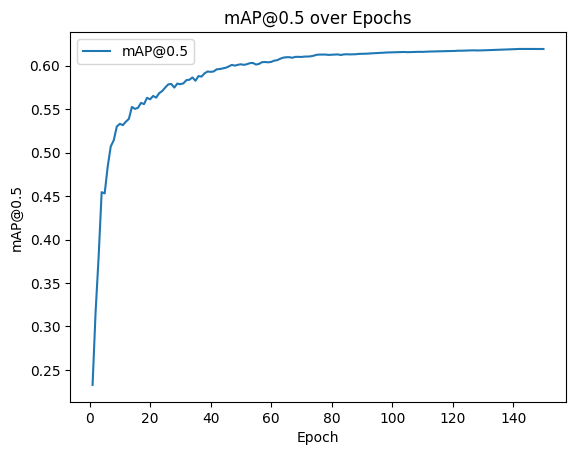

In [1]:
#  Visualize Training Logs
import pandas as pd
import matplotlib.pyplot as plt

# Load the training results
results = pd.read_csv("runs/obb/train_1650_yolo11n_obb/results.csv")

# Plot mAP over epochs
plt.plot(results['epoch'], results['metrics/mAP50(B)'], label='mAP@0.5')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.title('mAP@0.5 over Epochs')
plt.legend()
plt.show()

In [ ]:
#Mostrar lista de classes aprendidas
from ultralytics import YOLO

# Carregue o modelo
model = YOLO("runs/obb/train_1650_yolo11s/weights/best.pt")

# Print das classes aprendidas
print("📚 Classes aprendidas pelo modelo:")
for i, name in enumerate(model.names):
    print(f"{i}: {name}")

📚 Classes aprendidas pelo modelo:
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6


In [5]:
#Precision por classe
from ultralytics import YOLO

# Carrega o modelo treinado
model = YOLO("runs/obb/train_1650_yolo11n_obb/weights/best.pt")

# Avaliar o modelo no conjunto de validação
metrics = model.val(data="mtg.yaml", imgsz=640, iou=0.5)

# Pega os nomes das classes
names = model.names

# Imprime métricas por classe
print("\n📊 Desempenho por classe:")
for i, name in names.items():
    precision, recall, map50, map50_95 = metrics.class_result(i)
    print(f"Classe {i} ({name}):")
    print(f"  - Precision:      {precision:.2f}")
    print(f"  - Recall:         {recall:.2f}")
    print(f"  - mAP@0.5:        {map50:.2f}")
    print(f"  - mAP@0.5:0.95:   {map50_95:.2f}")


Ultralytics 8.3.102  Python-3.10.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 SUPER, 4096MiB)
YOLO11n-obb summary (fused): 109 layers, 2,655,088 parameters, 0 gradients, 6.6 GFLOPs


val: Scanning E:\mtg-card-detector\datasets\data\labels\test.cache... 3000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:00<?, ?it/s]

val: WARNING  E:\mtg-card-detector\datasets\data\images\test\0.jpg: 3 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1.jpg: 2 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1016.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1018.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1026.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1035.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1055.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\108.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1113.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-detector\datasets\data\images\test\1127.jpg: 1 duplicate labels removed
val: WARNING  E:\mtg-card-d


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:58<00:00,  3.20it/s]


                   all       3000       9606      0.896      0.566      0.621      0.569
                Branco        942       1123      0.896      0.519      0.597      0.541
                  Azul        917       1084      0.929      0.589      0.636      0.588
                 Preto        982       1172      0.866      0.562      0.609      0.563
              Vermelho       1071       1271      0.912      0.618      0.657      0.604
                 Verde       1026       1270      0.929      0.554      0.605      0.549
               Incolor       1676       2292      0.906      0.544      0.623      0.565
              Multicor       1148       1394      0.837      0.577      0.622      0.572
Speed: 1.1ms preprocess, 5.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\obb\val2

📊 Desempenho por classe:
Classe 0 (Branco):
  - Precision:      0.90
  - Recall:         0.52
  - mAP@0.5:        0.60
  - mAP@0.5:0.95:   0.54
Classe 1 (Azul):
  - Precision